In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot
import scipy.stats as ss

### Simple Regression

In [7]:
# True paramaters

nsize = 1000
true_beta1 = 5.0
true_beta2 = -5.0
true_alpha = 2.5
true_error = .5

# Predicttor variables (measurements on data)
X1 = np.random.normal(5,20, nsize)
X2 = np.random.normal(5,1, nsize)
e = np.random.normal(0,true_error, nsize)

#simulated outcome (sampled response data)
u = true_alpha + true_beta1*X1 + true_beta2*X2 + e

In [8]:
# Plotting the Data
canvas = toyplot.Canvas(width=600, height=250)
ax0 = canvas.cartesian(grid = (1,2,0), ylabel = "Beta 1", xlabel = "X1")
ax1 = canvas.cartesian(grid = (1,2,1), ylabel = "Beta2", xlabel = "X2")
ax0.scatterplot(X1, u)
ax1.scatterplot(X2, u);

<circl

In [14]:
with pm.Model() as model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=20)
    betas = pm.Normal('betas', mu=0, sd=1, shape=2)
    sigma = pm.HalfNormal('sigma', sd=.5)

    # Expected value of outcome
    mu = alpha + betas[0]*X1 + betas[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=u)

In [15]:
# get maximum likelihood
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = -713.98, ||grad|| = 0.25106: 100%|██████████| 63/63 [00:00<00:00, 1323.35it/s]   


{'alpha': array(2.3845016925499456),
 'betas': array([ 5.00074003, -4.98182447]),
 'sigma': array(0.47898712870347837),
 'sigma_log__': array(-0.7360815531149758)}

In [16]:
with model:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, betas, alpha]
The acceptance probability does not match the target. It is 0.964882151524, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.954653373279, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.384028,0.075282,0.000568,2.235165,2.529208,15223.0,0.999963
betas__0,5.000764,0.000759,0.000016,4.999264,5.002210,2383.0,0.999981
betas__1,-4.981758,0.014851,0.000115,-5.010839,-4.952679,15259.0,0.999956
sigma,0.480218,0.010834,0.000105,0.458458,0.500395,12410.0,1.000036


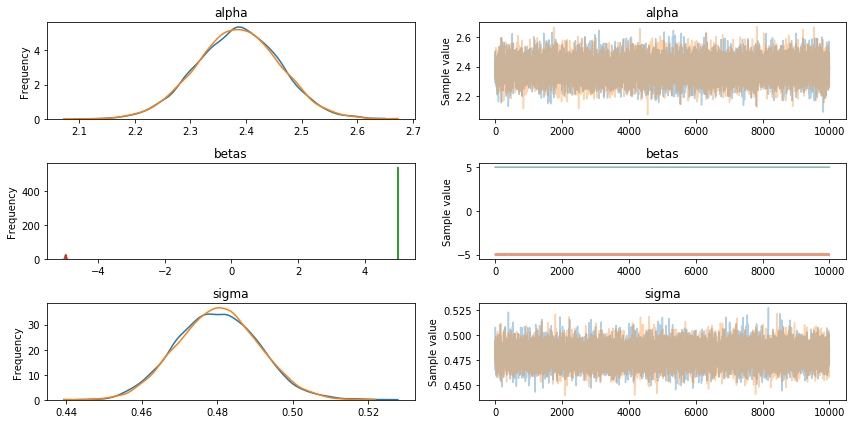

In [17]:
pm.traceplot(trace);
pm.summary(trace)

### In this regression model, the model predicted values that were very close to my generated parameters. The parameters were both within the 95% HPD. The alpha had the largest standard deviation value (sd = .075). I do think that my MCMC sampler ran for long enough, and I didnt run into any problems for this set of parameters. 

### Complex Model

In [18]:
# fix a random seed

np.random.seed(12345)

# generate data for 199 years with higher rates before 1920
data = pd.DataFrame({
    "year": np.arange(1500, 2015),
    "disasters": np.concatenate([
        np.random.poisson(7.0, 400),
        np.random.poisson(2.5, 115),
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 20)
data.loc[missing, "disasters"] = np.nan

In [19]:
data.head()

,disasters,year
0,10.0,1500
1,2.0,1501
2,15.0,1502
3,3.0,1503
4,9.0,1504


In [20]:
# plot the generated data
toyplot.scatterplot(
    data.year,
    data.disasters, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="N disasters",
);

1500 1600 1700 1800 1900 2000 year 0 5 10 15 N disasters

In [21]:
with pm.Model() as disaster_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1800)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=data.disasters)

In [22]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


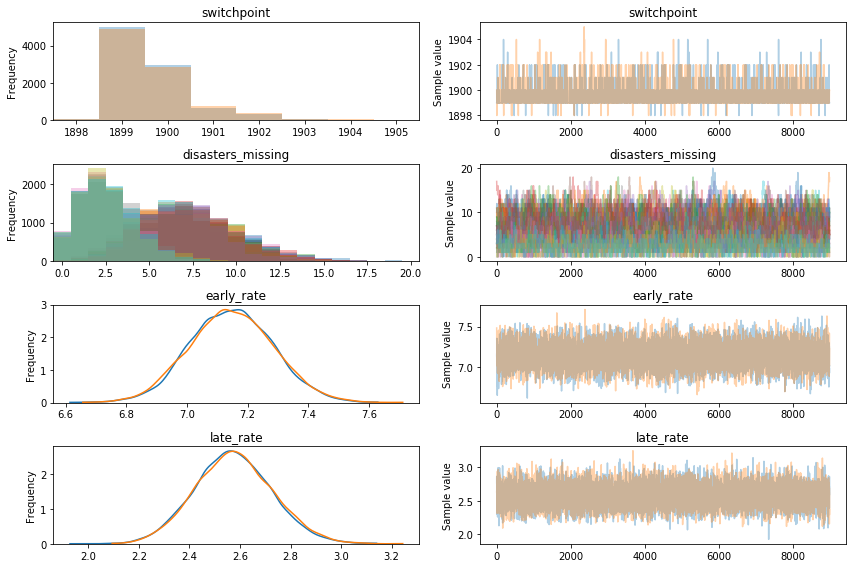

In [23]:
pm.traceplot(trace[1000:]);

In [24]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1899.612050,0.880139,0.015688,1898.000000,1901.000000,2092.0,0.999963
disasters_missing__0,6.732550,2.917005,0.212099,0.000000,11.000000,14.0,1.026375
disasters_missing__1,6.984400,3.138783,0.232105,0.000000,12.000000,45.0,0.999981
disasters_missing__2,6.932600,3.010657,0.219193,0.000000,12.000000,37.0,1.000561
disasters_missing__3,6.574950,2.982546,0.209294,0.000000,12.000000,38.0,1.029681
disasters_missing__4,6.897850,3.039098,0.230010,0.000000,12.000000,34.0,1.004890
disasters_missing__5,7.108600,3.129426,0.227462,0.000000,12.000000,27.0,1.005490
disasters_missing__6,7.276950,2.977490,0.221882,0.000000,12.000000,37.0,1.015020
disasters_missing__7,6.397450,2.941748,0.222726,0.000000,11.000000,45.0,1.026206
disasters_missing__8,6.899550,2.938343,0.217518,0.000000,12.000000,26.0,1.042864


### In this model, I generated random data over a longer time period compared to the 10.6 example and generated more missing data points. The summary shows that the model predicted the parameters closely. Both the early rate and the late rate had similar standard deviations. Both parameters were also within the 95% HPD interval. I don't think that anything went wrong, the sampler ran for a reasonable amount of time, and I didn't have to trouble shoot any issues. 